# 02 – Feature Engineering
Transform the raw play-by-play table into the full feature matrix (cumulative events, engineered interactions, and targets) that powers every subsequent notebook.


In [1]:
import sys
from pathlib import Path

def _find_project_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / 'src').is_dir():
            return candidate
    raise RuntimeError("Could not locate project root containing a 'src' directory.")

PROJECT_ROOT = _find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data.ingest import load_play_by_play
from src.features.build_features import build_feature_dataframe
from src.utils.paths import RAW_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR

PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
(REPORTS_DIR / 'figures').mkdir(parents=True, exist_ok=True)
RAW_PBP_PATH = RAW_DATA_DIR / 'play_by_play_combined.csv'
RAW_PBP_PATH


PosixPath('/Users/ludovicopasquali/Desktop/Bocconi TA/Group Project 4/group-project-4/data/raw/play_by_play_combined.csv')

## Step 1: load + inspect
Establish the raw data location and confirm we're reading the combined play-by-play export inside this repository.

In [3]:
def load_full_pbp(path: Path) -> pd.DataFrame:
    pbp = load_play_by_play(path)
    pbp = pbp.copy()

    matchup = pbp['game_id'].str.split(':', n=1).str[1].fillna('')
    home_names = matchup.str.split('-', n=1).str[0].str.strip()
    away_names = matchup.str.split('-', n=1).str[1].fillna('').str.strip()
    pbp['home_team_name'] = home_names
    pbp['away_team_name'] = away_names

    pbp['team_side'] = 'NA'
    pbp.loc[pbp['team_id'] == pbp['home_team_name'], 'team_side'] = 'HOME'
    pbp.loc[pbp['team_id'] == pbp['away_team_name'], 'team_side'] = 'AWAY'

    numeric_casts = ['action_number', 'period', 'home_score', 'away_score']
    for column in numeric_casts:
        pbp[column] = pbp[column].astype(int)
    pbp['remaining_period_time'] = pbp['remaining_period_time'].astype(float)
    return pbp

pbp_all = load_full_pbp(RAW_PBP_PATH)
pbp_all.shape


(828504, 29)

## Step 2: hydrate play-by-play columns
Derive helper columns (`home_team_name`, `away_team_name`, `team_side`) and ensure numeric fields use the right dtypes before feature construction.

In [4]:
pbp_all.head()

,season_id,edition_id,game_id,action_number,period,home_score,away_score,remaining_period_time,type,player_id,...,h4,h5,a1,a2,a3,a4,a5,home_team_name,away_team_name,team_side
0,20-21,20-21 EL,2020-10-01:Anadolu Efes Istanbul-Zenit St Pete...,1,1,0,0,600.0,GS,NaN,...,Krunoslav Simon,Vasilije Micic,Alex Poythress,Austin Hollins,Kc Rivers,Kevin Pangos,Will Thomas,Anadolu Efes Istanbul,Zenit St Petersburg,NA
1,20-21,20-21 EL,2020-10-01:Anadolu Efes Istanbul-Zenit St Pete...,2,1,0,0,600.0,PS,NaN,...,Krunoslav Simon,Vasilije Micic,Alex Poythress,Austin Hollins,Kc Rivers,Kevin Pangos,Will Thomas,Anadolu Efes Istanbul,Zenit St Petersburg,NA
2,20-21,20-21 EL,2020-10-01:Anadolu Efes Istanbul-Zenit St Pete...,3,1,0,0,600.0,JB,Bryant Dunston,...,Krunoslav Simon,Vasilije Micic,Alex Poythress,Austin Hollins,Kc Rivers,Kevin Pangos,Will Thomas,Anadolu Efes Istanbul,Zenit St Petersburg,HOME
3,20-21,20-21 EL,2020-10-01:Anadolu Efes Istanbul-Zenit St Pete...,4,1,0,0,600.0,JB,Alex Poythress,...,Krunoslav Simon,Vasilije Micic,Alex Poythress,Austin Hollins,Kc Rivers,Kevin Pangos,Will Thomas,Anadolu Efes Istanbul,Zenit St Petersburg,AWAY
4,20-21,20-21 EL,2020-10-01:Anadolu Efes Istanbul-Zenit St Pete...,5,1,0,0,599.0,JBW,NaN,...,Krunoslav Simon,Vasilije Micic,Alex Poythress,Austin Hollins,Kc Rivers,Kevin Pangos,Will Thomas,Anadolu Efes Istanbul,Zenit St Petersburg,HOME


## Step 3: build feature matrix
Feed the enriched play-by-play frame into `build_feature_dataframe`, which adds cumulative stats, engineered interactions, efficiency metrics (eFG/TS/REB/TOV/FTr), and momentum indicators before persisting `features_full.csv`.


In [5]:
# Build features and persist
feature_df = build_feature_dataframe(pbp_all, side_col='team_side')
feature_path = PROCESSED_DATA_DIR / 'features_full.csv'
feature_df.to_csv(feature_path, index=False)
feature_df.shape


(828504, 82)

## Step 4: quick EDA
Validate that the engineered features look sensible by plotting the distribution of `home_point_diff`. Extend this section with more plots if needed for QA.

PosixPath('/Users/ludovicopasquali/Desktop/Bocconi TA/Group Project 4/group-project-4/reports/figures/eda_home_point_diff.png')

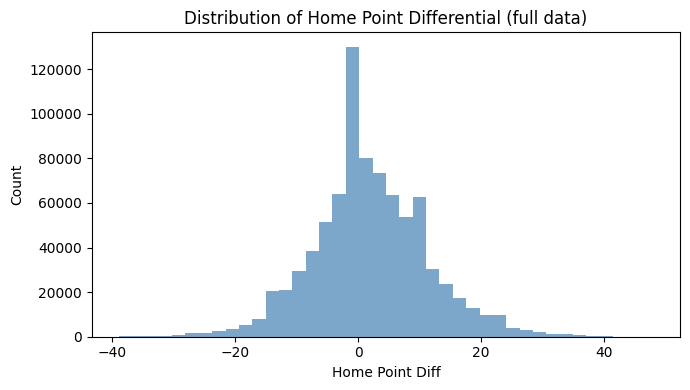

In [6]:
# Quick EDA plot: home point differential over time (full dataset)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(feature_df['home_point_diff'], bins=40, alpha=0.7, color='steelblue')
ax.set_title('Distribution of Home Point Differential (full data)')
ax.set_xlabel('Home Point Diff')
ax.set_ylabel('Count')
fig.tight_layout()
fig_path = REPORTS_DIR / 'figures' / 'eda_home_point_diff.png'
fig.savefig(fig_path, dpi=150)
fig_path


## Notes
- Uses `data/raw/play_by_play_combined.csv` as the canonical raw source; refresh that file locally to regenerate `features_full.csv`.
- Outputs the exact columns consumed by the modeling pipeline (`remaining_time_transformed`, `time_point_diff_interaction`, cumulative stats, etc.).
- `features_full.csv` stays under `data/processed/` (gitignored) so the repo remains public-safe while preserving your full dataset locally.
